SPREAD ANALYSIS OF BASKET AND ITS ITEMS

In [11]:
# Imports
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt

project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
    print(f"Added project root to sys.path: {project_root}")


dashboard_path = os.path.join(project_root, 'dashboard')
if dashboard_path not in sys.path:
    sys.path.insert(0, dashboard_path) 
    print(f"Added dashboard directory to sys.path: {dashboard_path}")

try:
    
    from historical_data_loader import load_historical_data
    print("Successfully imported historical_data_loader.")
except ImportError as e:
    print(f"Error importing historical_data_loader: {e}")
    print(f"Attempted project root: {project_root}")
    print(f"Attempted dashboard path: {dashboard_path}")
    print(f"Current sys.path: {sys.path}")
    
    print("\nERROR: Could not import historical_data_loader.")
    print("Please ensure 'dashboard/historical_data_loader.py' exists and the paths above are correct.")
    
    raise


DATA_DIR = 'C:/Users/Admin/projects/prosperity-poj/strategy/round2/resources/round2'


if not os.path.isdir(DATA_DIR):
    print(f"ERROR: Data directory not found: {DATA_DIR}")
    print("Please verify the DATA_DIR path is correct.")
    


print(f"\nAttempting to load data from: {DATA_DIR}")

if 'load_historical_data' in globals():
    historical_data = load_historical_data(DATA_DIR)
else:
    print("ERROR: load_historical_data function not available.")
    historical_data = {} 

all_prices = []
if historical_data:
    print(f"\nLoaded data for days: {list(historical_data.keys())}")
    
    sorted_days = sorted(historical_data.keys())
    for day in sorted_days:
        day_data = historical_data[day]
        
        if 'prices' in day_data and isinstance(day_data['prices'], pd.DataFrame) and not day_data['prices'].empty:
            
            if 'day' not in day_data['prices'].columns:
                 day_data['prices']['day'] = day
                 print(f"  Manually added 'day' column for day {day}.")
            all_prices.append(day_data['prices'])
            print(f"  Appending prices for day {day}, shape: {day_data['prices'].shape}")
        else:
            print(f"  Warning: No valid price data found or loaded for day {day}.")

if all_prices:
    try:
        combined_prices_df = pd.concat(all_prices, ignore_index=True)
        print(f"\nSuccessfully combined price data.")
        print(f"Combined prices DataFrame shape: {combined_prices_df.shape}")
        print("\nCombined prices DataFrame head:")
        print(combined_prices_df.head())
        print("\nCombined prices DataFrame info:")
        combined_prices_df.info()
        
        print("\nUnique products in loaded data:")
        print(combined_prices_df['product'].unique())
        print("\nTimestamps range from:", combined_prices_df['timestamp'].min(), "to", combined_prices_df['timestamp'].max())
        print(f"\nData types:\n{combined_prices_df.dtypes}")

    except Exception as e:
        print(f"\nError during concatenation or initial analysis: {e}")
        combined_prices_df = pd.DataFrame() 
else:
    print("\nError: No price data could be loaded or combined. Cannot proceed.")
    combined_prices_df = pd.DataFrame() 

if combined_prices_df.empty:
    print("\nResult: combined_prices_df is empty. Check data loading steps and paths.")


Successfully imported historical_data_loader.

Attempting to load data from: C:/Users/Admin/projects/prosperity-poj/strategy/round2/resources/round2
Loading historical data for Round 2 from: C:/Users/Admin/projects/prosperity-poj/strategy/round2/resources/round2
  Loaded prices for day -1 from prices_round_2_day_-1.csv
  Loaded trades for day -1 from trades_round_2_day_-1_nn.csv
  Loaded prices for day 0 from prices_round_2_day_0.csv
  Loaded trades for day 0 from trades_round_2_day_0_nn.csv
  Loaded prices for day 1 from prices_round_2_day_1.csv
  Loaded trades for day 1 from trades_round_2_day_1_nn.csv

Loaded data for days: [-1, 0, 1]
  Appending prices for day -1, shape: (80000, 17)
  Appending prices for day 0, shape: (80000, 17)
  Appending prices for day 1, shape: (80000, 17)

Successfully combined price data.
Combined prices DataFrame shape: (240000, 17)

Combined prices DataFrame head:
   day  timestamp         product  bid_price_1  bid_volume_1  bid_price_2  \
0   -1         

In [12]:

if not combined_prices_df.empty:
    print("Pivoting the combined price data...")
    prices_pivot = combined_prices_df.pivot_table(
        index=['day', 'timestamp'],
        columns='product',
        values='mid_price' 
    )
    print(f"Pivot table created with shape: {prices_pivot.shape}")
    print(f"Pivot table columns: {prices_pivot.columns.tolist()}")

    
    print("Forward-filling missing values...")
    initial_na_counts = prices_pivot.isna().sum()
    prices_pivot.ffill(inplace=True)
    final_na_counts = prices_pivot.isna().sum()
    filled_counts = initial_na_counts - final_na_counts
    print(f"NaN values filled:\n{filled_counts[filled_counts > 0]}") 

    
    initial_rows = prices_pivot.shape[0]
    prices_pivot.dropna(inplace=True)
    print(f"Dropped {initial_rows - prices_pivot.shape[0]} rows with remaining NaNs after ffill.")

    
    basket1_components = {'CROISSANTS': 6, 'JAMS': 3, 'DJEMBES': 1}
    basket2_components = {'CROISSANTS': 4, 'JAMS': 2}

    # --- Calculate Synthetic Basket 1 ---
    required_cols_b1 = list(basket1_components.keys()) + ['PICNIC_BASKET1']
    if all(col in prices_pivot.columns for col in required_cols_b1):
        print("\nCalculating Synthetic Basket 1 and Spread...")
        prices_pivot['SYNTHETIC_BASKET1'] = 0
        for product, quantity in basket1_components.items():
            prices_pivot['SYNTHETIC_BASKET1'] += quantity * prices_pivot[product]

        # Calculate Spread 1
        prices_pivot['SPREAD_BASKET1'] = prices_pivot['PICNIC_BASKET1'] - prices_pivot['SYNTHETIC_BASKET1']
        print("-> Calculation for Basket 1 completed.")
    else:
        missing_cols = [col for col in required_cols_b1 if col not in prices_pivot.columns]
        print(f"\nWarning: Missing columns required for Basket 1 calculation: {missing_cols}. Skipping Basket 1.")
        if 'SPREAD_BASKET1' in prices_pivot.columns: prices_pivot.drop(columns=['SPREAD_BASKET1'], inplace=True) # Clean up if partially calculated
        if 'SYNTHETIC_BASKET1' in prices_pivot.columns: prices_pivot.drop(columns=['SYNTHETIC_BASKET1'], inplace=True)


    # --- Calculate Synthetic Basket 2 ---
    required_cols_b2 = list(basket2_components.keys()) + ['PICNIC_BASKET2']
    if all(col in prices_pivot.columns for col in required_cols_b2):
        print("\nCalculating Synthetic Basket 2 and Spread...")
        prices_pivot['SYNTHETIC_BASKET2'] = 0
        for product, quantity in basket2_components.items():
            prices_pivot['SYNTHETIC_BASKET2'] += quantity * prices_pivot[product]

        
        prices_pivot['SPREAD_BASKET2'] = prices_pivot['PICNIC_BASKET2'] - prices_pivot['SYNTHETIC_BASKET2']
        print("-> Calculation for Basket 2 completed.")
    else:
        missing_cols = [col for col in required_cols_b2 if col not in prices_pivot.columns]
        print(f"\nWarning: Missing columns required for Basket 2 calculation: {missing_cols}. Skipping Basket 2.")
        if 'SPREAD_BASKET2' in prices_pivot.columns: prices_pivot.drop(columns=['SPREAD_BASKET2'], inplace=True) # Clean up
        if 'SYNTHETIC_BASKET2' in prices_pivot.columns: prices_pivot.drop(columns=['SYNTHETIC_BASKET2'], inplace=True)

    # --- Display results ---
    print("\n--- Results ---")
    
    display_cols = [col for col in ['PICNIC_BASKET1', 'SYNTHETIC_BASKET1', 'SPREAD_BASKET1',
                                   'PICNIC_BASKET2', 'SYNTHETIC_BASKET2', 'SPREAD_BASKET2']
                    if col in prices_pivot.columns] # Only show columns that were actually calculated

    if display_cols:
        print("\nPivot table with calculated spreads (head):")
        print(prices_pivot[display_cols].head())
        print("\nPivot table with calculated spreads (tail):")
        print(prices_pivot[display_cols].tail())
        print("\nSpread statistics:")
        spread_cols = [col for col in display_cols if 'SPREAD' in col]
        if spread_cols:
             print(prices_pivot[spread_cols].describe())
        else:
             print("No spread columns were calculated.")
    else:
        print("\nCould not calculate any spreads due to missing columns or empty initial data.")

else:
    print("\ncombined_prices_df is empty. Skipping calculations.")
    prices_pivot = pd.DataFrame() # Ensure it exists as empty df


if prices_pivot.empty:
     print("\nResult: prices_pivot DataFrame is empty. Check previous steps.")

Pivoting the combined price data...
Pivot table created with shape: (30000, 8)
Pivot table columns: ['CROISSANTS', 'DJEMBES', 'JAMS', 'KELP', 'PICNIC_BASKET1', 'PICNIC_BASKET2', 'RAINFOREST_RESIN', 'SQUID_INK']
Forward-filling missing values...
NaN values filled:
Series([], dtype: int64)
Dropped 0 rows with remaining NaNs after ffill.

Calculating Synthetic Basket 1 and Spread...
-> Calculation for Basket 1 completed.

Calculating Synthetic Basket 2 and Spread...
-> Calculation for Basket 2 completed.

--- Results ---

Pivot table with calculated spreads (head):
product        PICNIC_BASKET1  SYNTHETIC_BASKET1  SPREAD_BASKET1  \
day timestamp                                                      
-1  0                 59289.0            59289.0             0.0   
    100               59287.0            59288.5            -1.5   
    200               59293.5            59290.5             3.0   
    300               59293.5            59293.0             0.5   
    400               5

Creating continuous timestamp...
Continuous timestamp created.
Plotting calculated spreads using continuous timestamp...


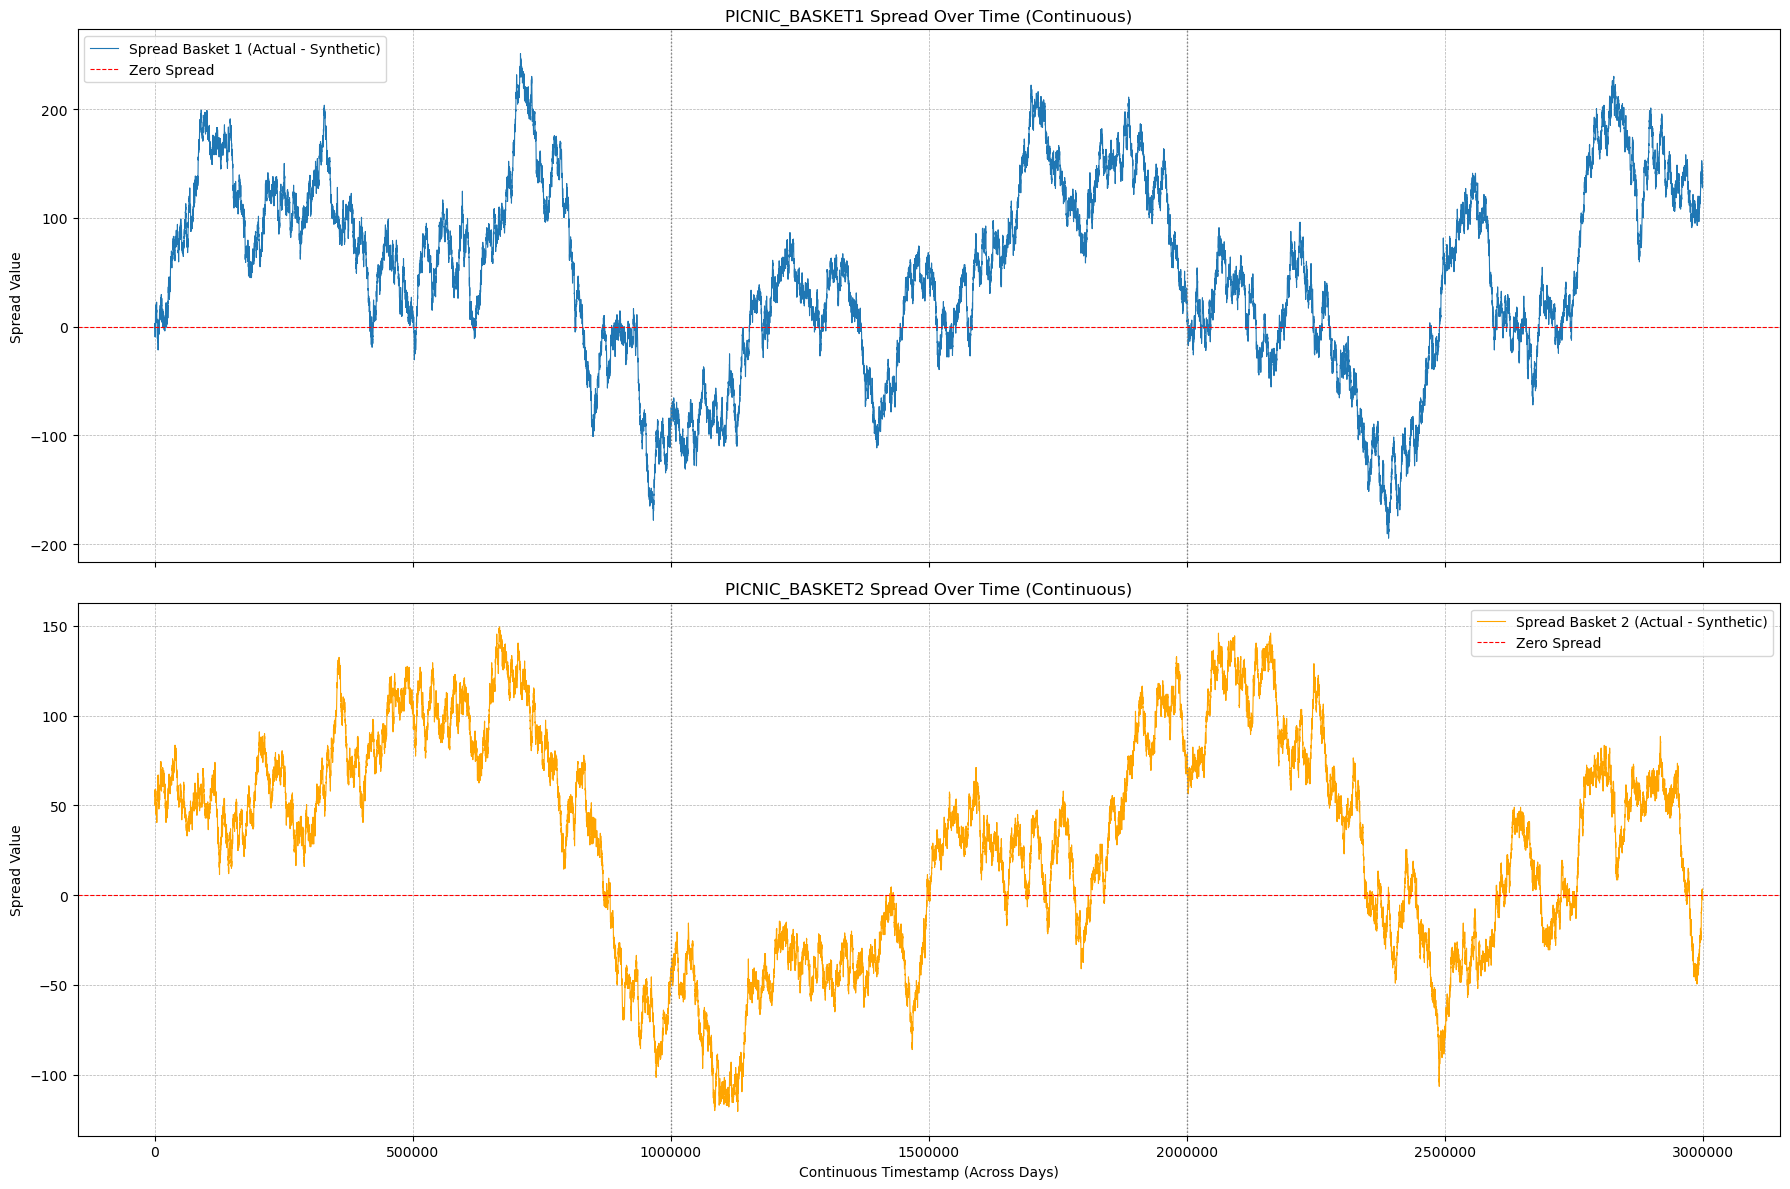

In [16]:



# Create a continuous timestamp across days for plotting

if 'prices_pivot' in globals() and not prices_pivot.empty:
    # Reset index if not already done, to access 'day' and 'timestamp' as columns
    if isinstance(prices_pivot.index, pd.MultiIndex):
        prices_pivot_reset = prices_pivot.reset_index()
    else:
        # If it's already reset or has a different index, ensure 'day' and 'timestamp' columns exist
        if 'day' not in prices_pivot.columns or 'timestamp' not in prices_pivot.columns:
             print("Error: 'day' or 'timestamp' columns missing after reset/pivot.")
             # Handle error appropriately, maybe try resetting again or stop
             prices_pivot_reset = pd.DataFrame() # Avoid further errors
        else:
             prices_pivot_reset = prices_pivot # Assume it's already suitable

    if not prices_pivot_reset.empty:
        print("Creating continuous timestamp...")
        # Calculate offset for each day. Max timestamp is 999900. Use 1,000,000 as interval.
        day_offset = {
            -1: 0,
            0: 1000000, # Offset for day 0
            1: 2000000  # Offset for day 1
        }
        prices_pivot_reset['continuous_timestamp'] = prices_pivot_reset.apply(
            lambda row: row['timestamp'] + day_offset.get(row['day'], 0),
            axis=1
        )
        print("Continuous timestamp created.")

        # --- Now plot using the continuous timestamp ---

        plot_spread1 = 'SPREAD_BASKET1' in prices_pivot_reset.columns
        plot_spread2 = 'SPREAD_BASKET2' in prices_pivot_reset.columns

        if plot_spread1 or plot_spread2:
            print("Plotting calculated spreads using continuous timestamp...")
            num_plots = sum([plot_spread1, plot_spread2])
            fig, axes = plt.subplots(num_plots, 1, figsize=(18, 6 * num_plots), sharex=True) # Increased width

            if num_plots == 1:
                axes = [axes]

            plot_index = 0

            # Plot Spread 1 if available
            if plot_spread1:
                ax = axes[plot_index]
                # Use continuous_timestamp for x-axis
                ax.plot(prices_pivot_reset['continuous_timestamp'], prices_pivot_reset['SPREAD_BASKET1'], label='Spread Basket 1 (Actual - Synthetic)', linewidth=0.8)
                ax.axhline(0, color='red', linestyle='--', linewidth=0.8, label='Zero Spread')
                ax.set_title('PICNIC_BASKET1 Spread Over Time (Continuous)')
                ax.set_ylabel('Spread Value')
                ax.legend()
                ax.grid(True, which='both', linestyle='--', linewidth=0.5)
                # Add vertical lines for day boundaries
                for day, offset in day_offset.items():
                     if day > -1: # Mark start of day 0 and day 1
                         ax.axvline(offset, color='gray', linestyle=':', linewidth=1)
                plot_index += 1

            # Plot Spread 2 if available
            if plot_spread2:
                ax = axes[plot_index]
                # Use continuous_timestamp for x-axis
                ax.plot(prices_pivot_reset['continuous_timestamp'], prices_pivot_reset['SPREAD_BASKET2'], label='Spread Basket 2 (Actual - Synthetic)', color='orange', linewidth=0.8)
                ax.axhline(0, color='red', linestyle='--', linewidth=0.8, label='Zero Spread')
                ax.set_title('PICNIC_BASKET2 Spread Over Time (Continuous)')
                ax.set_ylabel('Spread Value')
                ax.legend()
                ax.grid(True, which='both', linestyle='--', linewidth=0.5)
                 # Add vertical lines for day boundaries
                for day, offset in day_offset.items():
                     if day > -1: # Mark start of day 0 and day 1
                         ax.axvline(offset, color='gray', linestyle=':', linewidth=1)
                plot_index += 1

            # Common X axis label
            axes[-1].set_xlabel('Continuous Timestamp (Across Days)') # Label only the last plot's x-axis
            # Format x-axis ticks for readability if needed
            axes[-1].ticklabel_format(style='plain', axis='x')


            plt.tight_layout()
            plt.show()
        else:
            print("No spread columns available for plotting.")
    else:
        print("Failed to prepare prices_pivot_reset for plotting.")

else:
    print("prices_pivot DataFrame not found or is empty. Cannot plot spreads.")

MEAN REVERSION TEST FOR BASKET1

--- Analyzing Spread: SPREAD_BASKET1 ---
count    30000.000000
mean        48.762433
std         85.119451
min       -194.500000
25%         -5.000000
50%         51.000000
75%        112.500000
max        251.000000
Name: SPREAD_BASKET1, dtype: float64
ADF Statistic: -3.180184999630061
p-value: 0.021160682756257015
Critical Values: {'1%': -3.4305680243931267, '5%': -2.861636360888007, '10%': -2.5668212899601888}
Reject the null hypothesis: The series is stationary.

Calculating Rolling Mean, Standard Deviation, and Z-Score...
Plotting Spread, Fix Mean, Rolling Std Dev, and Z-Score...


ValueError: x and y must have same first dimension, but have shapes (29918,) and (1,)

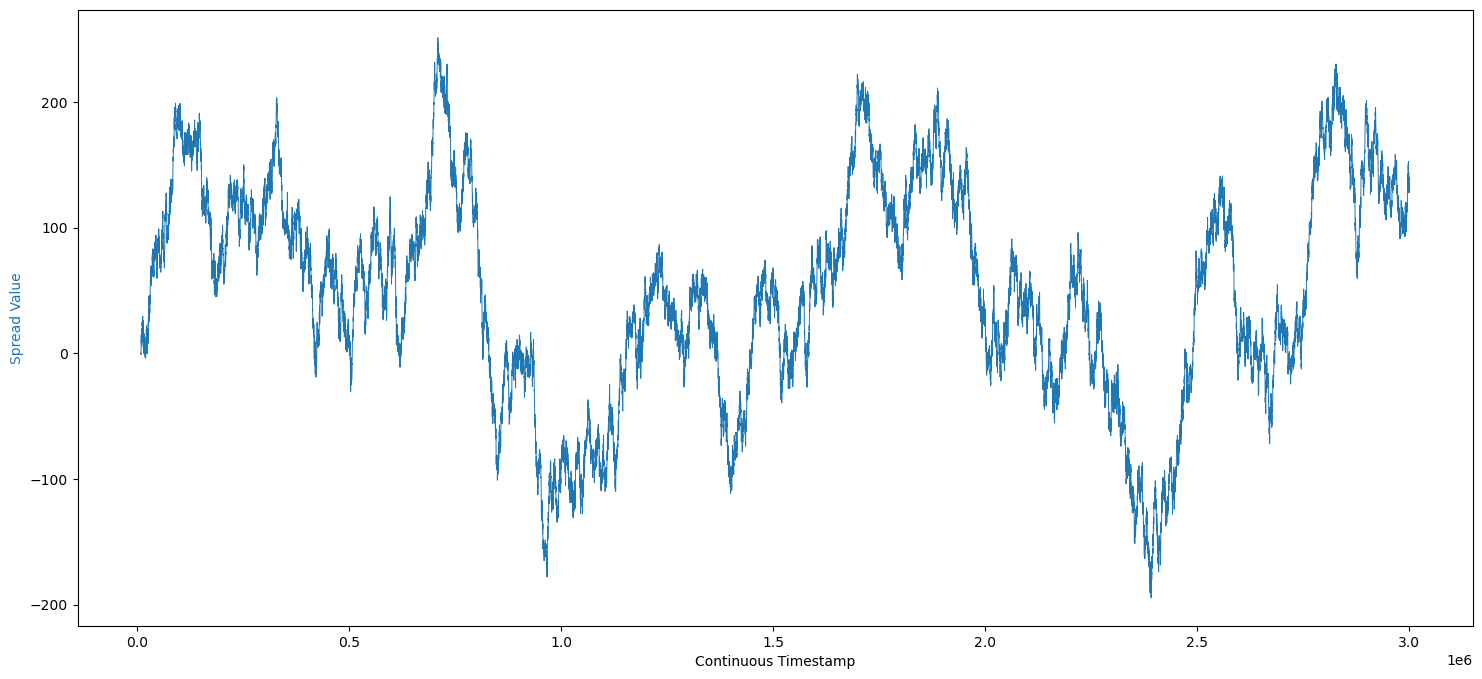

In [14]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
import warnings # To suppress potential warnings if variance is exactly zero
import numpy as np # Ensure numpy is imported
import matplotlib.pyplot as plt # Ensure matplotlib is imported

# --- Analysis: Check for Mean Reversion ---

# Choose the spread to analyze (change if needed)
spread_column = 'SPREAD_BASKET1' # Or 'SPREAD_BASKET2'

if 'prices_pivot_reset' in globals() and spread_column in prices_pivot_reset.columns:
    print(f"--- Analyzing Spread: {spread_column} ---")
    spread_data = prices_pivot_reset[spread_column].dropna() # Use data after dropping initial NaNs
    print(spread_data.describe())
    
    #ADF TEST
    adf_result = adfuller(spread_data)
    print(f"ADF Statistic: {adf_result[0]}")
    print(f"p-value: {adf_result[1]}")
    print(f"Critical Values: {adf_result[4]}")
    #interpret the results
    if adf_result[1] < 0.05:
        print("Reject the null hypothesis: The series is stationary.")
    else:
        print("Fail to reject the null hypothesis: The series is non-stationary.")

    if not spread_data.empty:
        # 1. Calculate Rolling Statistics & Z-Score
        print("\nCalculating Rolling Mean, Standard Deviation, and Z-Score...")
        window_size = max(100, len(spread_data) // 100) # Use same window for mean
        std_window_size = 83 # Potentially different window for std dev, adjust if needed
        fixed_mean = 48.7
        rolling_std = spread_data.rolling(window=std_window_size).std()
        # Add a small epsilon to prevent division by zero
        epsilon = 1e-8
        z_score = (spread_data - fixed_mean) / (rolling_std + epsilon)

        # Ensure z_score index aligns with spread_data after rolling calculations might drop initial values
        # We need to plot against the correct timestamps corresponding to the valid z_score values
        valid_indices = z_score.dropna().index

        # 2. Plotting with Secondary Y-axis for Z-score
        print("Plotting Spread, Fix Mean, Rolling Std Dev, and Z-Score...")
        fig, ax1 = plt.subplots(figsize=(18, 8)) # Create figure and primary axes

        # Plot spread and rolling mean on primary axis (ax1) using valid_indices
        color1 = 'tab:blue'
        ax1.set_xlabel('Continuous Timestamp')
        ax1.set_ylabel('Spread Value', color=color1)
        # Plotting only the portion where all rolling calculations are valid
        line1, = ax1.plot(prices_pivot_reset.loc[valid_indices, 'continuous_timestamp'], spread_data.loc[valid_indices], label='Original Spread', color=color1, linewidth=0.7)
        line2, = ax1.plot(prices_pivot_reset.loc[valid_indices, 'continuous_timestamp'], fixed_mean, label=f'Rolling Mean (win={window_size})', color='red', linewidth=1)
        ax1.tick_params(axis='y', labelcolor=color1)
        ax1.grid(True, which='major', axis='x', linestyle='--', linewidth=0.5) # Grid only on x for primary

        # Create secondary axis (ax2) for Z-score
        ax2 = ax1.twinx()
        color2 = 'tab:green'
        ax2.set_ylabel('Z-Score', color=color2)
        # Plot Z-score using valid_indices
        line4, = ax2.plot(prices_pivot_reset.loc[valid_indices, 'continuous_timestamp'], z_score.loc[valid_indices], label='Z-Score', color=color2, linewidth=1)
        ax2.tick_params(axis='y', labelcolor=color2)

        # Add Z-score threshold lines
        z_threshold = 2 # Example threshold
        line5 = ax2.axhline(z_threshold, color=color2, linestyle='--', linewidth=0.8, label=f'Z = +{z_threshold}')
        line6 = ax2.axhline(-z_threshold, color=color2, linestyle='--', linewidth=0.8, label=f'Z = -{z_threshold}')
        line7 = ax2.axhline(0, color='grey', linestyle=':', linewidth=0.5, label='Z = 0') # Zero line for reference


        # Combine legends
        # Ensure line handles are correctly referenced
        lines = [line1, line2, line4, line5, line6, line7] # Get handles for threshold lines from ax2
        labels = [l.get_label() for l in lines]
        # Place legend slightly outside the plot if needed
        ax1.legend(lines, labels, loc='upper left', bbox_to_anchor=(0, 0.95))


        plt.title(f'{spread_column} with Rolling Mean and Z-Score (Secondary Axis)')
        fig.tight_layout() # Adjust layout
        plt.show()

        # --- Analysis of Z-score distribution (Optional) ---
        print(f"\nZ-Score Description ({spread_column}):")
        print(z_score.describe())
        plt.figure(figsize=(10, 4))
        z_score.hist(bins=50)
        plt.title(f'Z-Score Distribution - {spread_column}')
        plt.xlabel('Z-Score')
        plt.ylabel('Frequency')
        plt.grid(True, axis='y', linestyle=':')
        plt.show()


    else:
        print(f"No data available in {spread_column} after dropping NaNs.")

elif 'prices_pivot_reset' not in globals():
     print("Error: prices_pivot_reset DataFrame not found. Run the previous cell.")
else:
    print(f"Error: Column '{spread_column}' not found in prices_pivot_reset.")



BASKET1 MEAN = 48.7 BASKET2 MEAN = 30.2

In [15]:
# --- Calculate Spread between Basket 1 and Basket 2 ---

# Ensure mid-prices exist (replace column names if different)
# Example: df_prices['PICNIC_BASKET1_mid'] = (df_prices[('PICNIC_BASKET1', 'bid_price_1')] + df_prices[('PICNIC_BASKET1', 'ask_price_1')]) / 2
# Example: df_prices['PICNIC_BASKET2_mid'] = (df_prices[('PICNIC_BASKET2', 'bid_price_1')] + df_prices[('PICNIC_BASKET2', 'ask_price_1')]) / 2
# Example: df_prices['CROISSANTS_mid'] = ...
# Example: df_prices['JAMS_mid'] = ...
# Example: df_prices['DJEMBES_mid'] = ...


# --- Calculate Spread between Basket 1 and Basket 2 ---

# Define required columns based on direct product names
required_b1_b2_cols = ['PICNIC_BASKET1', 'PICNIC_BASKET2', 'CROISSANTS', 'JAMS', 'DJEMBES']

# Check if all necessary columns exist in prices_pivot
if all(col in prices_pivot.columns for col in required_b1_b2_cols):
    print("\nCalculating actual and theoretical spreads between Basket 1 and Basket 2...")

    # Calculate the actual spread B1 - B2 using the correct column names
    prices_pivot['B1_minus_B2_spread'] = prices_pivot['PICNIC_BASKET1'] - prices_pivot['PICNIC_BASKET2']

    # Calculate the theoretical spread based on components using correct column names
    prices_pivot['theoretical_B1_minus_B2_spread'] = (2 * prices_pivot['CROISSANTS'] +
                                                    1 * prices_pivot['JAMS'] +
                                                    1 * prices_pivot['DJEMBES'])

    print("-> Calculation for B1-B2 spreads completed.")

    # --- Display B1-B2 Spread Info ---
    print("\nB1 vs B2 Spread Info (Head):")
    print(prices_pivot[['B1_minus_B2_spread', 'theoretical_B1_minus_B2_spread']].head())
    print("\nB1 vs B2 Spread Info (Tail):")
    print(prices_pivot[['B1_minus_B2_spread', 'theoretical_B1_minus_B2_spread']].tail())
    print("\nB1 vs B2 Spread Statistics:")
    print(prices_pivot[['B1_minus_B2_spread', 'theoretical_B1_minus_B2_spread']].describe())

    # Flag to indicate that plotting is possible
    plot_b1_b2_spread = True

else:
    missing_cols = [col for col in required_b1_b2_cols if col not in prices_pivot.columns]
    print(f"\nWarning: Missing columns required for B1-B2 spread calculation: {missing_cols}. Skipping B1-B2 spread.")
    plot_b1_b2_spread = False # Prevent plotting if columns are missing


# --- Plot Spread between Basket 1 and Basket 2 (using continuous timestamp) ---
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Check if the required columns exist in the DataFrame used for plotting (prices_pivot_reset)
# Also check the flag from the calculation step
if 'plot_b1_b2_spread' in locals() and plot_b1_b2_spread and \
   'B1_minus_B2_spread' in prices_pivot_reset.columns and \
   'theoretical_B1_minus_B2_spread' in prices_pivot_reset.columns:

    print("\nPlotting B1 vs B2 spreads using continuous timestamp...")

    fig_b1_b2 = make_subplots(rows=1, cols=1, shared_xaxes=True,
                            subplot_titles=("Spread between PICNIC_BASKET1 and PICNIC_BASKET2",))

    # Plot Actual Spread
    fig_b1_b2.add_trace(go.Scatter(x=prices_pivot_reset['continuous_timestamp'], y=prices_pivot_reset['B1_minus_B2_spread'],
                                 mode='lines', name='Actual Spread (B1 - B2)'),
                      row=1, col=1)

    # Plot Theoretical Spread
    fig_b1_b2.add_trace(go.Scatter(x=prices_pivot_reset['continuous_timestamp'], y=prices_pivot_reset['theoretical_B1_minus_B2_spread'],
                                 mode='lines', name='Theoretical Spread (2C+1J+1D)',
                                 line=dict(dash='dash', color='orange')),
                      row=1, col=1)


    fig_b1_b2.update_layout(height=450, title_text="PICNIC_BASKET1 vs PICNIC_BASKET2 Spread Analysis (Continuous)", legend_title_text='Spread Type')
    fig_b1_b2.update_yaxes(title_text="Price Difference (Seashells)", row=1, col=1)
    fig_b1_b2.update_xaxes(title_text="Continuous Timestamp", row=1, col=1)

    # Add vertical lines for day boundaries if day_offset exists
    if 'day_offset' in locals():
        for day, offset in day_offset.items():
            if day > -1: # Mark start of day 0 and day 1
                fig_b1_b2.add_vline(x=offset, line_dash="dot", line_color="grey")

    fig_b1_b2.show()

else:
    print("\nSkipping plot for B1 vs B2 spread because required columns are missing or calculation failed.")



Calculating actual and theoretical spreads between Basket 1 and Basket 2...
-> Calculation for B1-B2 spreads completed.

B1 vs B2 Spread Info (Head):
product        B1_minus_B2_spread  theoretical_B1_minus_B2_spread
day timestamp                                                    
-1  0                     28680.0                         28730.0
    100                   28674.0                         28729.5
    200                   28678.5                         28730.5
    300                   28673.0                         28731.0
    400                   28671.0                         28735.5

B1 vs B2 Spread Info (Tail):
product        B1_minus_B2_spread  theoretical_B1_minus_B2_spread
day timestamp                                                    
1   999500                28603.0                         28475.5
    999600                28604.5                         28474.0
    999700                28603.0                         28474.5
    999800                2

### Analysis: Spread between PICNIC_BASKET1 and PICNIC_BASKET2

Theoretically, `PICNIC_BASKET1` (6 Croissants, 3 Jams, 1 Djembe) should differ from `PICNIC_BASKET2` (4 Croissants, 2 Jams) by the price of the extra components: **2 Croissants + 1 Jam + 1 Djembe**.

The plot below shows:
- The **Actual Spread** (blue line): Calculated as `PICNIC_BASKET1 Mid-Price - PICNIC_BASKET2 Mid-Price`.
- The **Theoretical Spread** (dashed orange line): Calculated as `2 * CROISSANTS Mid-Price + 1 * JAMS Mid-Price + 1 * DJEMBES Mid-Price`.

Deviations between the actual and theoretical spread could indicate potential arbitrage opportunities or market inefficiencies, although transaction costs and bid-ask spreads need to be considered for actual trading. When the blue line is significantly above the orange line, B1 might be overpriced relative to B2 and its components. When the blue line is significantly below, B1 might be underpriced.

In [17]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np # Ensure numpy is imported

# --- Calculate and Plot the Deviation Z-Score ---

# Check if the required columns exist in prices_pivot_reset
required_cols_zscore = ['B1_minus_B2_spread', 'theoretical_B1_minus_B2_spread', 'continuous_timestamp']

if all(col in prices_pivot_reset.columns for col in required_cols_zscore):
    print("\nCalculating and plotting the Z-Score of the B1-B2 spread deviation...")

    # 1. Calculate the deviation (if not already done)
    if 'B1_B2_spread_deviation' not in prices_pivot_reset.columns:
        prices_pivot_reset['B1_B2_spread_deviation'] = prices_pivot_reset['B1_minus_B2_spread'] - prices_pivot_reset['theoretical_B1_minus_B2_spread']

    # 2. Calculate overall mean of the deviation
    deviation_mean = prices_pivot_reset['B1_B2_spread_deviation'].mean()
    print(f"Overall Mean Deviation: {deviation_mean:.2f}")

    # 3. Calculate rolling standard deviation of the deviation
    # Choose a window size - adjust as needed, e.g., 1000 timestamps = 100 seconds
    rolling_window_size = 97
    prices_pivot_reset['B1_B2_deviation_rolling_std'] = prices_pivot_reset['B1_B2_spread_deviation'].rolling(window=rolling_window_size, min_periods=rolling_window_size // 4).std() # Adjusted min_periods

    # 4. Calculate the Z-score
    # Avoid division by zero or near-zero std dev
    prices_pivot_reset['B1_B2_deviation_zscore'] = np.where(
        prices_pivot_reset['B1_B2_deviation_rolling_std'] > 1e-6, # Check if std is reasonably large
        (prices_pivot_reset['B1_B2_spread_deviation'] - deviation_mean) / prices_pivot_reset['B1_B2_deviation_rolling_std'],
        np.nan # Assign NaN if std dev is too small or zero
    )

    # 5. Create figure with secondary y-axis
    fig_deviation_zscore = make_subplots(rows=1, cols=1, shared_xaxes=True,
                                          specs=[[{"secondary_y": True}]]) # Enable secondary axis

    # Plot the primary data: Spread Deviation
    fig_deviation_zscore.add_trace(go.Scatter(x=prices_pivot_reset['continuous_timestamp'],
                                              y=prices_pivot_reset['B1_B2_spread_deviation'],
                                              mode='lines', name='Spread Deviation (Actual - Theoretical)',
                                              line=dict(color='royalblue')),
                           secondary_y=False) # Assign to primary y-axis

    # Plot the mean deviation line on the primary axis
    fig_deviation_zscore.add_trace(go.Scatter(x=prices_pivot_reset['continuous_timestamp'],
                                               y=[deviation_mean] * len(prices_pivot_reset),
                                               mode='lines', name=f'Mean Deviation ({deviation_mean:.2f})',
                                               line=dict(color='grey', dash='dash')),
                           secondary_y=False) # Assign to primary y-axis

    # Plot the secondary data: Z-Score
    fig_deviation_zscore.add_trace(go.Scatter(x=prices_pivot_reset['continuous_timestamp'],
                                              y=prices_pivot_reset['B1_B2_deviation_zscore'],
                                              mode='lines', name='Deviation Z-Score',
                                              line=dict(color='orange', width=1.5)),
                           secondary_y=True) # Assign to secondary y-axis

    # Add horizontal lines for Z-score levels (e.g., +/- 1, 2) on the secondary axis
    for z_level in [1, 2, -1, -2]:
        fig_deviation_zscore.add_hline(y=z_level, line_dash="dot", line_color="rgba(255, 165, 0, 0.5)", secondary_y=True)


    # Update layout titles
    fig_deviation_zscore.update_layout(
        height=500,
        title_text="B1-B2 Spread Deviation and its Z-Score (Continuous)",
        legend_title_text='Metric'
    )

    # Update y-axes titles
    fig_deviation_zscore.update_yaxes(title_text="Deviation (Seashells)", secondary_y=False, color='royalblue')
    fig_deviation_zscore.update_yaxes(title_text="Z-Score", secondary_y=True, color='orange', showgrid=False) # Hide grid for secondary axis for clarity

    # Update x-axis title
    fig_deviation_zscore.update_xaxes(title_text="Continuous Timestamp")

    # Add vertical lines for day boundaries if day_offset exists
    if 'day_offset' in locals():
        for day, offset in day_offset.items():
            if day > -1:
                fig_deviation_zscore.add_vline(x=offset, line_dash="dot", line_color="grey")

    fig_deviation_zscore.show()

    # Optional: Display statistics for the Z-score
    print("\nSpread Deviation Z-Score Statistics:")
    print(prices_pivot_reset['B1_B2_deviation_zscore'].describe())

else:
    missing_cols = [col for col in required_cols_zscore if col not in prices_pivot_reset.columns]
    print(f"\nSkipping Z-score plot for B1-B2 spread deviation because required columns are missing: {missing_cols}")

#Conduct ADF test

adf_result = adfuller(prices_pivot_reset['B1_B2_spread_deviation'])
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print(f"Critical Values: {adf_result[4]}")
#interpret the results
if adf_result[1] < 0.05:
    print("Reject the null hypothesis: The series is stationary.")
else:
    print("Fail to reject the null hypothesis: The series is non-stationary.")









Calculating and plotting the Z-Score of the B1-B2 spread deviation...
Overall Mean Deviation: 18.53



Spread Deviation Z-Score Statistics:
count    29977.000000
mean         0.470365
std          7.281758
min        -26.093692
25%         -4.674990
50%          0.343843
75%          5.186095
max         26.954603
Name: B1_B2_deviation_zscore, dtype: float64
ADF Statistic: -3.8629909755748653
p-value: 0.002324740482179035
Critical Values: {'1%': -3.430568009855954, '5%': -2.8616363544632057, '10%': -2.566821286540422}
Reject the null hypothesis: The series is stationary.
